In [1]:
#Step 1: Data Preprocessing


import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import os


def preprocess_itu_ml5g(input_path: str, output_path: str):
    print("🔹 Loading dataset...")
    df = pd.read_csv(input_path)
    print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")

    # --- Step 1: Clean column names ---
    df.columns = df.columns.str.strip()
    print("🔹 Cleaned column names")

    print("Columns:", [repr(c) for c in df.columns])

    # --- Step 2: Auto-detect label column ---
    possible_labels = ["Label", "label", "Attack", "attack", "Class", "class", "Target"]
    label_col = next((col for col in df.columns if col.strip() in possible_labels), None)

    if label_col is None:
        raise ValueError("❌ Label column not found. Check CSV header.")

    print(f"✔ Using label column: {label_col}")

    # --- Step 3: Basic cleaning ---
    print("🔹 Removing duplicates...")
    df.drop_duplicates(inplace=True)

    print("🔹 Handling missing values...")
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)

    # --- Step 4: Separate label and features ---
    y = df[label_col]
    X = df.drop(columns=[label_col])

    # --- Step 5: Identify categorical columns ---
    categorical_cols = [c for c in X.columns if X[c].dtype == "object"]
    numeric_cols = [c for c in X.columns if X[c].dtype != "object"]

    print(f"Found {len(categorical_cols)} categorical and {len(numeric_cols)} numeric columns.")

    # --- Step 6: IP/MAC handling (not encoded) ---
    ip_like_cols = [c for c in categorical_cols if "ip" in c.lower() or "mac" in c.lower()]
    other_cats = [c for c in categorical_cols if c not in ip_like_cols]

    print("IP/MAC columns (kept as-is):", ip_like_cols)
    print("Categorical columns to encode:", other_cats)

    # --- Step 7: One-hot encode categorical columns ---
    if other_cats:
        encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
        encoded = encoder.fit_transform(X[other_cats])
        encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(other_cats))

        X = pd.concat([
            X.drop(columns=other_cats).reset_index(drop=True),
            encoded_df.reset_index(drop=True)
        ], axis=1)

    # --- Step 8: Re-detect numeric columns AFTER encoding ---
    numeric_cols = [c for c in X.columns if X[c].dtype != "object" and c not in ip_like_cols]

    print(f"🔹 Numeric columns to normalize (after encoding): {len(numeric_cols)}")

    # --- Step 9: Scale numeric features ---
    print("🔹 Fixing infinite values before scaling...")
    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    X.fillna(0, inplace=True)

    print("🔹 Scaling numeric features...")
    scaler = StandardScaler()
    X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

    # --- Step 10: Combine final dataset ---
    df_cleaned = pd.concat([X, y.reset_index(drop=True)], axis=1)

    # --- Step 11: Save cleaned dataset ---
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    df_cleaned.to_csv(output_path, index=False)

    print(f"✅ Cleaned dataset saved to: {output_path}")
    print(f"Final shape: {df_cleaned.shape}")


# --- MAIN EXECUTION ---
if __name__ == "__main__":
    input_path = "/kaggle/input/itu-ml5g-ps-006/Train_ULAK.csv"
    output_path = "/kaggle/working/itu_ml5g_cleaned2.csv"
    preprocess_itu_ml5g(input_path, output_path)


🔹 Loading dataset...
Dataset loaded: 1783356 rows, 79 columns
🔹 Cleaned column names
Columns: ["'Destination Port'", "'Flow Duration'", "'Total Fwd Packets'", "'Total Backward Packets'", "'Total Length of Fwd Packets'", "'Total Length of Bwd Packets'", "'Fwd Packet Length Max'", "'Fwd Packet Length Min'", "'Fwd Packet Length Mean'", "'Fwd Packet Length Std'", "'Bwd Packet Length Max'", "'Bwd Packet Length Min'", "'Bwd Packet Length Mean'", "'Bwd Packet Length Std'", "'Flow Bytes/s'", "'Flow Packets/s'", "'Flow IAT Mean'", "'Flow IAT Std'", "'Flow IAT Max'", "'Flow IAT Min'", "'Fwd IAT Total'", "'Fwd IAT Mean'", "'Fwd IAT Std'", "'Fwd IAT Max'", "'Fwd IAT Min'", "'Bwd IAT Total'", "'Bwd IAT Mean'", "'Bwd IAT Std'", "'Bwd IAT Max'", "'Bwd IAT Min'", "'Fwd PSH Flags'", "'Bwd PSH Flags'", "'Fwd URG Flags'", "'Bwd URG Flags'", "'Fwd Header Length'", "'Bwd Header Length'", "'Fwd Packets/s'", "'Bwd Packets/s'", "'Min Packet Length'", "'Max Packet Length'", "'Packet Length Mean'", "'Packet Len

In [2]:
# Step 1: Install required packages

# First install torch if not already installed
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

# Install PyTorch Geometric
!pip install torch_geometric

print("Installation completed!")

# Step 2: Graph Construction - Fixed Label Handling
print("Building graph with fixed label handling")

import torch
import pandas as pd
import numpy as np
from torch_geometric.data import Data

def fix_label_column(df):
    """Fix the Label column by converting to numeric"""
    if 'Label' in df.columns:
        print("Fixing Label column...")
        print(f"   Current dtype: {df['Label'].dtype}")
        print(f"   Sample values: {df['Label'].head(3).tolist()}")
        
        df_fixed = df.copy()
        df_fixed['Label'] = pd.to_numeric(df_fixed['Label'], errors='coerce')
        
        nan_count = df_fixed['Label'].isna().sum()
        if nan_count > 0:
            print(f"   {nan_count} NaN values found after conversion, filling with 0")
            df_fixed['Label'] = df_fixed['Label'].fillna(0)
        
        df_fixed['Label'] = df_fixed['Label'].astype(int)
        
        print(f"   Fixed dtype: {df_fixed['Label'].dtype}")
        print(f"   Fixed sample values: {df_fixed['Label'].head(3).tolist()}")
        print(f"   Label distribution: {dict(df_fixed['Label'].value_counts().head())}")
        
        return df_fixed
    return df

def build_safe_graph(df, num_flows=500, num_hosts=25):
    """Safe graph construction with robust label handling"""
    print("Building safe graph")
    
    df_small = df.head(num_flows).copy()
    df_small = fix_label_column(df_small)
    
    print(f" Using {len(df_small)} flows and {num_hosts} hosts")
    
    # Step 1: Select numeric features 
    numeric_cols = [col for col in df_small.columns if col != 'Label' and pd.api.types.is_numeric_dtype(df_small[col])]
    feature_cols = numeric_cols[:10]  # First 10 numeric features
    print(f"Using {len(feature_cols)} numeric features")
    
    for col in feature_cols:
        df_small[col] = pd.to_numeric(df_small[col], errors='coerce').fillna(0)
    
    x_flow = torch.tensor(df_small[feature_cols].values, dtype=torch.float)
    print(f"Flow features shape: {x_flow.shape}")
    
    # Step 2: Create bipartite edges 
    edge_index = []
    for i in range(len(df_small)):
        host1 = num_flows + (i % num_hosts)
        host2 = num_flows + ((i + 1) % num_hosts)
        edge_index.append([i, host1])
        edge_index.append([i, host2])
    
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    print(f"Edge index shape: {edge_index.shape}")
    
    # Step 3: Host features (average of connected flows) 
    x_host = torch.zeros((num_hosts, x_flow.shape[1]))
    host_counts = torch.zeros(num_hosts)
    for i in range(len(df_small)):
        host1_idx = i % num_hosts
        host2_idx = (i + 1) % num_hosts
        x_host[host1_idx] += x_flow[i]
        x_host[host2_idx] += x_flow[i]
        host_counts[host1_idx] += 1
        host_counts[host2_idx] += 1
    
    for i in range(num_hosts):
        if host_counts[i] > 0:
            x_host[i] /= host_counts[i]
    
    x = torch.cat([x_flow, x_host], dim=0)
    print(f"Combined features shape: {x.shape}")
    
    # Step 4: Labels 
    if 'Label' in df_small.columns:
        labels_np = df_small['Label'].values
        if labels_np.dtype == np.object_:
            labels_np = pd.to_numeric(df_small['Label'], errors='coerce').fillna(0).astype(int).values
        y_flow = torch.tensor(labels_np, dtype=torch.long)
        y_host = torch.full((num_hosts,), -1, dtype=torch.long)
        y = torch.cat([y_flow, y_host], dim=0)
        print(f"Labels created. Unique values: {torch.unique(y_flow)}")
    else:
        y = None
        print("No Label column found")
    
    # Step 5: Graph data 
    data = Data(x=x, edge_index=edge_index, y=y)
    data.num_flows = len(df_small)
    data.num_hosts = num_hosts
    
    print("Safe graph construction completed!")
    print(f"Nodes: {data.num_nodes} (Flows: {data.num_flows}, Hosts: {data.num_hosts})")
    print(f"Edges: {data.num_edges}")
    print(f"Features: {x.shape[1]}")
    
    return data

def build_minimal_working_graph(df, num_flows=200, num_hosts=10):
    print("Building minimal working graph")
    
    df_mini = df.head(num_flows).copy()
    
    if 'Label' in df_mini.columns:
        df_mini['Label'] = pd.to_numeric(df_mini['Label'], errors='coerce').fillna(0).astype(int)
        print(f"Labels: {df_mini['Label'].value_counts().to_dict()}")
    else:
        df_mini['Label'] = 0
        print("No labels found, using all zeros")
    
    numeric_cols = [col for col in df_mini.columns if col != 'Label' and pd.api.types.is_numeric_dtype(df_mini[col])]
    feature_cols = numeric_cols[:5]
    print(f"Using features: {feature_cols}")
    
    for col in feature_cols:
        df_mini[col] = pd.to_numeric(df_mini[col], errors='coerce').fillna(0)
    
    x_flow = torch.tensor(df_mini[feature_cols].values, dtype=torch.float)
    
    edge_index = []
    for i in range(len(df_mini)):
        host1 = num_flows + (i % num_hosts)
        host2 = num_flows + ((i + 1) % num_hosts)
        edge_index.append([i, host1])
        edge_index.append([i, host2])
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    
    x_host = torch.zeros((num_hosts, x_flow.shape[1]))
    x = torch.cat([x_flow, x_host], dim=0)
    
    y_flow = torch.tensor(df_mini['Label'].values, dtype=torch.long)
    y_host = torch.full((num_hosts,), -1, dtype=torch.long)
    y = torch.cat([y_flow, y_host], dim=0)
    
    data = Data(x=x, edge_index=edge_index, y=y)
    data.num_flows = len(df_mini)
    data.num_hosts = num_hosts
    
    print(f"Minimal graph: {data.num_nodes} nodes, {data.num_edges} edges")
    return data

# MAIN EXECUTION 
try:
    df_cleaned = pd.read_csv("/kaggle/working/itu_ml5g_cleaned2.csv", low_memory=False)
    print(f"Loaded data: {df_cleaned.shape}")
    
    print("\n Choose computation level:")
    print("1. MINIMAL (200 flows, 10 hosts) - Guaranteed")
    print("2. SMALL (500 flows, 25 hosts) - Balanced") 
    print("3. MEDIUM (1000 flows, 50 hosts) - More data")
    print("4. LARGE (5000 flows, 200 hosts) - Full-scale")
    
    choice = 4  # Using LARGE graph
    
    if choice == 1:
        graph_data = build_minimal_working_graph(df_cleaned, num_flows=200, num_hosts=10)
        save_path = '/kaggle/working/itu_minimal_graph.pt'
    elif choice == 2:
        graph_data = build_safe_graph(df_cleaned, num_flows=500, num_hosts=25)
        save_path = '/kaggle/working/itu_small_graph.pt'
    elif choice == 3:
        graph_data = build_safe_graph(df_cleaned, num_flows=1000, num_hosts=50)
        save_path = '/kaggle/working/itu_medium_graph.pt'
    else:
        graph_data = build_safe_graph(df_cleaned, num_flows=5000, num_hosts=200)
        save_path = '/kaggle/working/itu_large_graph.pt'
    
    torch.save(graph_data, save_path)
    print(f" Graph saved to: {save_path}")
    
    print("\n FINAL GRAPH SUMMARY:")
    print(f"   Total nodes: {graph_data.num_nodes}")
    print(f"   Flow nodes: {graph_data.num_flows}") 
    print(f"   Host nodes: {graph_data.num_hosts}")
    print(f"   Edges: {graph_data.num_edges}")
    print(f"   Features: {graph_data.x.shape[1]}")
    
    if graph_data.y is not None:
        flow_labels = graph_data.y[:graph_data.num_flows]
        unique, counts = torch.unique(flow_labels, return_counts=True)
        print(f"   Label distribution: {dict(zip(unique.tolist(), counts.tolist()))}")
    
except Exception as e:
    print(f" Error: {e}")
    import traceback
    traceback.print_exc()
    
    # Last resort: create synthetic graph
    print("\n Creating synthetic graph as last resort")
    try:
        x_flow = torch.randn(100, 10)
        x_host = torch.zeros(20, 10)
        x = torch.cat([x_flow, x_host], dim=0)

        edge_index = []
        for i in range(100):
            edge_index.append([i, 100 + (i % 20)])
            edge_index.append([i, 100 + ((i + 1) % 20)])
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

        y_flow = torch.zeros(100, dtype=torch.long)
        y_host = torch.full((20,), -1, dtype=torch.long)
        y = torch.cat([y_flow, y_host], dim=0)

        graph_data = Data(x=x, edge_index=edge_index, y=y)
        graph_data.num_flows = 100
        graph_data.num_hosts = 20

        torch.save(graph_data, '/kaggle/working/itu_synthetic_graph.pt')
        print("Synthetic graph created and saved!")

    except Exception as e2:
        print(f"Even synthetic failed: {e2}")


Looking in indexes: https://download.pytorch.org/whl/cpu
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 MB 10.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: torch
    Found existing installation: torch 2.6.0+cu124
    Uninstalling torch-2.6.0+cu124:
      Successfully uninstalled torch-2.6.0+cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.5 MB/s eta 0:00:00a 0:00:01
Installation completed!
Building graph with fixed label handling
Loaded data: (1762738, 79)

 Choose computation level:
1. MINIMAL (200 flows, 10 hosts) - Guaranteed
2. SMALL (500 flows, 25 hosts) - Balanced
3. MEDIUM (1000 flows, 50 hosts) - More data
4. LARGE (5000 flows, 200 hosts) - Full-scale
Building safe graph
Fixing Label column...
   Current dtype: object
   Sample v

GraphSAGE
 LARGE SCALE GRAPHSAGE INTRUSION DETECTION
 Original dataset: (1762738, 79)
 Building large balanced graph with 5000 flows
 Original label distribution: {0: 5000}
 Using 15 features: ['Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets']...
 Creating balanced dataset with synthetic anomalies
 Balanced label distribution: {0: 3250, 1: 1750}
 Flow features shape: torch.Size([5000, 15])
 Edge index shape: torch.Size([2, 15000])
 Large balanced graph construction completed
 Nodes: 5200 (Flows: 5000, Hosts: 200)
 Edges: 15000
 Features: 15
Large balanced graph saved!
 Preparing large balanced data splits
   Dataset: 3250 normal, 1750 anomalies
 Large balanced splits:
   Train: 3500 flows (2275 normal, 1225 anomalies)
   Val: 749 flows (487 normal, 262 anomalies)
   Test: 751 flows (488 normal, 263 anomalies)
 Class weights: tensor([0.3500, 0.6500])

 Large Model Configuration:
   Input features: 15
   Hidden dimension: 1

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


   Epoch 020, Loss: 0.1519, Val Acc: 0.9613, Val F1: 0.9607, LR: 0.005000
   ⏹️  Early stopping at epoch 22
 Training completed!. Best validation F1: 0.9987


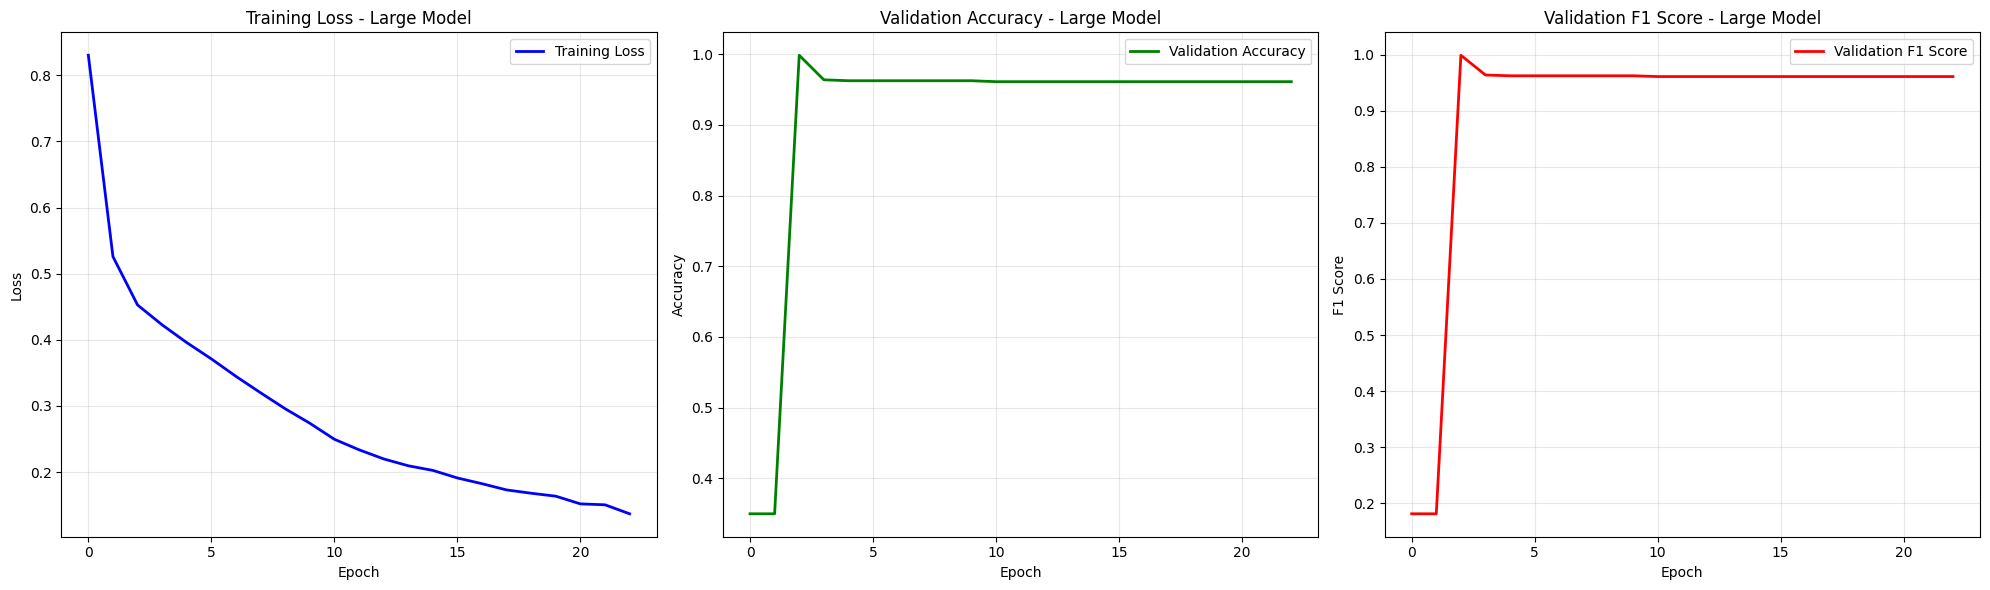


 Comprehensive Evaluation
   Test Results:
   Test Accuracy: 0.9987
   Test Samples: 751

 Detailed Classification Report:
              precision    recall  f1-score   support

      Normal     0.9980    1.0000    0.9990       488
     Anomaly     1.0000    0.9962    0.9981       263

    accuracy                         0.9987       751
   macro avg     0.9990    0.9981    0.9985       751
weighted avg     0.9987    0.9987    0.9987       751



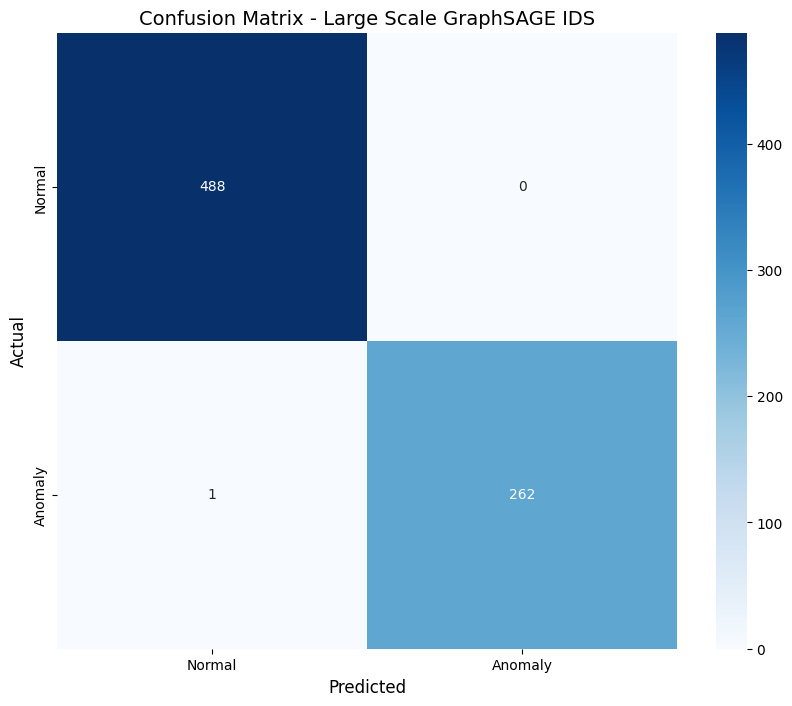


 Per-Class Performance:
   Normal - Precision: 0.9980, Recall: 1.0000, F1: 0.9990, Support: 488
   Anomaly - Precision: 1.0000, Recall: 0.9962, F1: 0.9981, Support: 263

 Overall Metrics:
   Macro F1: 0.9985
   Weighted F1: 0.9987
   Balanced Accuracy: 0.9987

 LARGE SCALE GRAPHSAGE IDS TRAINING COMPLETED!
   Model saved: /kaggle/working/large_graphsage_ids.pth
   Final Test Accuracy: 0.9987
   Total flows processed: 5,000
   Graph size: 5,200 nodes, 15,000 edges


In [3]:
# Step 4: Large-Scale Balanced GraphSAGE IDS

print("GraphSAGE")

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support, f1_score
import pandas as pd

def build_large_balanced_graph(df, num_flows=5000, num_hosts=100, anomaly_ratio=0.3):
    """
    Build large graph with balanced normal/anomaly distribution
    """
    print(f" Building large balanced graph with {num_flows} flows")
    
    # Take larger sample
    df_large = df.head(num_flows).copy()
    
    # Fix labels
    if 'Label' in df_large.columns:
        df_large['Label'] = pd.to_numeric(df_large['Label'], errors='coerce').fillna(0).astype(int)
    else:
        df_large['Label'] = 0
    
    print(f" Original label distribution: {df_large['Label'].value_counts().to_dict()}")
    
    # Select more features for better performance
    numeric_cols = []
    for col in df_large.columns:
        if col != 'Label' and pd.api.types.is_numeric_dtype(df_large[col]):
            numeric_cols.append(col)
    
    # Use more features for larger dataset
    feature_cols = numeric_cols[:15]  # First 15 numeric features
    print(f" Using {len(feature_cols)} features: {feature_cols[:5]}...")
    
    # Ensure all features are numeric
    for col in feature_cols:
        df_large[col] = pd.to_numeric(df_large[col], errors='coerce').fillna(0)
    
    # Create synthetic anomalies to balance the dataset
    print(" Creating balanced dataset with synthetic anomalies")
    
    # Calculate number of anomalies needed
    current_anomalies = (df_large['Label'] == 1).sum()
    target_anomalies = int(num_flows * anomaly_ratio)
    additional_anomalies_needed = target_anomalies - current_anomalies
    
    if additional_anomalies_needed > 0:
        # Select random normal flows to convert to anomalies
        normal_indices = df_large[df_large['Label'] == 0].index.tolist()
        anomaly_indices = np.random.choice(normal_indices, additional_anomalies_needed, replace=False)
        
        # Modify features to create realistic anomalies
        for idx in anomaly_indices:
            attack_type = np.random.choice(['port_scan', 'ddos', 'data_exfiltration', 'brute_force', 'botnet'])
            
            if attack_type == 'port_scan':
                df_large.loc[idx, 'Destination Port'] = np.random.randint(1000, 65535)
                df_large.loc[idx, 'Flow Duration'] = np.random.randint(1, 1000)
                df_large.loc[idx, 'Total Fwd Packets'] = np.random.randint(50, 200)
                
            elif attack_type == 'ddos':
                df_large.loc[idx, 'Flow Duration'] = np.random.randint(1, 100)
                df_large.loc[idx, 'Total Fwd Packets'] = np.random.randint(100, 1000)
                df_large.loc[idx, 'Total Length of Fwd Packets'] = np.random.randint(5000, 50000)
                
            elif attack_type == 'data_exfiltration':
                df_large.loc[idx, 'Total Length of Fwd Packets'] = np.random.randint(10000, 100000)
                df_large.loc[idx, 'Total Backward Packets'] = np.random.randint(1, 10)
                
            elif attack_type == 'brute_force':
                df_large.loc[idx, 'Destination Port'] = np.random.choice([22, 23, 3389, 5900])  # Common service ports
                df_large.loc[idx, 'Flow Duration'] = np.random.randint(100, 1000)
                df_large.loc[idx, 'Total Fwd Packets'] = np.random.randint(20, 100)
                
            elif attack_type == 'botnet':
                df_large.loc[idx, 'Flow Duration'] = np.random.randint(5000, 30000)  # Long connections
                df_large.loc[idx, 'Total Fwd Packets'] = np.random.randint(10, 50)  # Stealthy
            
            # Mark as anomaly
            df_large.loc[idx, 'Label'] = 1
    
    print(f" Balanced label distribution: {df_large['Label'].value_counts().to_dict()}")
    
    # Flow features
    x_flow = torch.tensor(df_large[feature_cols].values, dtype=torch.float)
    print(f" Flow features shape: {x_flow.shape}")
    
    # Create graph structure
    edge_index = []
    
    # Each flow connected to multiple hosts for richer structure
    for i in range(len(df_large)):
        # Connect to 3 different hosts for better graph connectivity
        host1 = num_flows + (i % num_hosts)
        host2 = num_flows + ((i + 1) % num_hosts)
        host3 = num_flows + ((i + 5) % num_hosts)  # Different host
        
        edge_index.append([i, host1])
        edge_index.append([i, host2])
        edge_index.append([i, host3])
    
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    print(f" Edge index shape: {edge_index.shape}")
    
    # Host features (average of connected flows)
    x_host = torch.zeros((num_hosts, x_flow.shape[1]))
    host_counts = torch.zeros(num_hosts)
    
    for i in range(len(df_large)):
        host1_idx = i % num_hosts
        host2_idx = (i + 1) % num_hosts
        host3_idx = (i + 5) % num_hosts
        
        x_host[host1_idx] += x_flow[i]
        x_host[host2_idx] += x_flow[i]
        x_host[host3_idx] += x_flow[i]
        host_counts[host1_idx] += 1
        host_counts[host2_idx] += 1
        host_counts[host3_idx] += 1
    
    # Avoid division by zero
    for i in range(num_hosts):
        if host_counts[i] > 0:
            x_host[i] = x_host[i] / host_counts[i]
    
    # Combine features
    x = torch.cat([x_flow, x_host], dim=0)
    
    # Labels
    y_flow = torch.tensor(df_large['Label'].values, dtype=torch.long)
    y_host = torch.full((num_hosts,), -1, dtype=torch.long)
    y = torch.cat([y_flow, y_host], dim=0)
    
    data = Data(x=x, edge_index=edge_index, y=y)
    data.num_flows = len(df_large)
    data.num_hosts = num_hosts
    
    print(" Large balanced graph construction completed")
    print(f" Nodes: {data.num_nodes} (Flows: {data.num_flows}, Hosts: {data.num_hosts})")
    print(f" Edges: {data.num_edges}")
    print(f" Features: {x.shape[1]}")
    
    return data

def prepare_large_balanced_splits(graph_data, train_ratio=0.7, val_ratio=0.15):
    """
    Prepare balanced splits for large dataset with stratification
    """
    print(" Preparing large balanced data splits")
    
    # Only use flow nodes
    flow_mask = graph_data.y != -1
    flow_indices = torch.where(flow_mask)[0].numpy()
    flow_labels = graph_data.y[flow_mask].numpy()
    
    # Separate by class
    normal_indices = flow_indices[flow_labels == 0]
    anomaly_indices = flow_indices[flow_labels == 1]
    
    print(f"   Dataset: {len(normal_indices)} normal, {len(anomaly_indices)} anomalies")
    
    # Calculate split sizes maintaining class balance
    normal_train_size = int(train_ratio * len(normal_indices))
    normal_val_size = int(val_ratio * len(normal_indices))
    
    anomaly_train_size = int(train_ratio * len(anomaly_indices))
    anomaly_val_size = int(val_ratio * len(anomaly_indices))
    
    # Create splits
    normal_train = normal_indices[:normal_train_size]
    normal_val = normal_indices[normal_train_size:normal_train_size + normal_val_size]
    normal_test = normal_indices[normal_train_size + normal_val_size:]
    
    anomaly_train = anomaly_indices[:anomaly_train_size]
    anomaly_val = anomaly_indices[anomaly_train_size:anomaly_train_size + anomaly_val_size]
    anomaly_test = anomaly_indices[anomaly_train_size + anomaly_val_size:]
    
    # Combine and shuffle
    train_indices = np.concatenate([normal_train, anomaly_train])
    val_indices = np.concatenate([normal_val, anomaly_val])
    test_indices = np.concatenate([normal_test, anomaly_test])
    
    np.random.shuffle(train_indices)
    np.random.shuffle(val_indices)
    np.random.shuffle(test_indices)
    
    # Create masks
    train_mask = torch.zeros(graph_data.num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(graph_data.num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(graph_data.num_nodes, dtype=torch.bool)
    
    train_mask[train_indices] = True
    val_mask[val_indices] = True
    test_mask[test_indices] = True
    
    graph_data.train_mask = train_mask
    graph_data.val_mask = val_mask
    graph_data.test_mask = test_mask
    
    print(f" Large balanced splits:")
    print(f"   Train: {train_mask.sum().item()} flows ({len(normal_train)} normal, {len(anomaly_train)} anomalies)")
    print(f"   Val: {val_mask.sum().item()} flows ({len(normal_val)} normal, {len(anomaly_val)} anomalies)")
    print(f"   Test: {test_mask.sum().item()} flows ({len(normal_test)} normal, {len(anomaly_test)} anomalies)")
    
    return graph_data

class LargeGraphSAGEIDS(nn.Module):
    """
    Enhanced GraphSAGE for large-scale intrusion detection
    """
    def __init__(self, input_dim, hidden_dim=128, output_dim=2, num_layers=3, dropout=0.3):
        super(LargeGraphSAGEIDS, self).__init__()
        
        self.convs = nn.ModuleList()
        
        # First layer
        self.convs.append(SAGEConv(input_dim, hidden_dim))
        
        # Hidden layers with decreasing dimensions
        self.convs.append(SAGEConv(hidden_dim, hidden_dim // 2))
        self.convs.append(SAGEConv(hidden_dim // 2, hidden_dim // 4))
        
        # Output layer
        self.convs.append(SAGEConv(hidden_dim // 4, output_dim))
        
        self.dropout = dropout
        self.batch_norms = nn.ModuleList([
            nn.BatchNorm1d(hidden_dim),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 4)
        ])
        
    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x, edge_index)
            x = self.batch_norms[i](x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Final layer
        x = self.convs[-1](x, edge_index)
        return F.log_softmax(x, dim=1)

def train_large_model(model, data, class_weights, epochs=150, lr=0.005, patience=20):
    """
    Train large model with advanced optimization
    """
    print(" Training the model")
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
    criterion = nn.NLLLoss(weight=class_weights)
    
    train_losses = []
    val_accuracies = []
    val_f1_scores = []
    
    best_val_f1 = 0
    patience_counter = 0
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_out = model(data.x, data.edge_index)
            val_pred = val_out[data.val_mask].argmax(dim=1)
            val_true = data.y[data.val_mask]
            
            val_acc = (val_pred == val_true).float().mean()
            
            # Calculate F1 score
            if len(torch.unique(val_true)) > 1:
                _, _, f1, _ = precision_recall_fscore_support(
                    val_true.cpu(), val_pred.cpu(), average='weighted'
                )
            else:
                f1 = val_acc.item()
        
        train_losses.append(loss.item())
        val_accuracies.append(val_acc.item())
        val_f1_scores.append(f1)
        
        # Learning rate scheduling
        scheduler.step(loss)
        
        # Early stopping
        if f1 > best_val_f1:
            best_val_f1 = f1
            patience_counter = 0
            torch.save(model.state_dict(), '/kaggle/working/best_large_graphsage.pth')
        else:
            patience_counter += 1
        
        if epoch % 20 == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f'   Epoch {epoch:03d}, Loss: {loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {f1:.4f}, LR: {current_lr:.6f}')
        
        if patience_counter >= patience:
            print(f'   ⏹️  Early stopping at epoch {epoch}')
            break
    
    # Load best model
    model.load_state_dict(torch.load('/kaggle/working/best_large_graphsage.pth'))
    print(f" Training completed!. Best validation F1: {best_val_f1:.4f}")
    
    return model, train_losses, val_accuracies, val_f1_scores

def evaluate_large_model(model, data):
    """
    Comprehensive evaluation for large model
    """
    print("\n Comprehensive Evaluation")
    
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        
        # Test set predictions
        test_pred = out[data.test_mask].argmax(dim=1)
        test_true = data.y[data.test_mask]
        
        # Calculate metrics
        test_accuracy = accuracy_score(test_true.cpu(), test_pred.cpu())
        
        print(f"   Test Results:")
        print(f"   Test Accuracy: {test_accuracy:.4f}")
        print(f"   Test Samples: {len(test_true)}")
        
        # Detailed metrics
        if len(torch.unique(test_true)) > 1:
            print("\n Detailed Classification Report:")
            print(classification_report(test_true.cpu(), test_pred.cpu(), 
                                      target_names=['Normal', 'Anomaly'],
                                      digits=4))
            
            # Confusion matrix
            cm = confusion_matrix(test_true.cpu(), test_pred.cpu())
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                       xticklabels=['Normal', 'Anomaly'],
                       yticklabels=['Normal', 'Anomaly'])
            plt.title('Confusion Matrix - Large Scale GraphSAGE IDS', fontsize=14)
            plt.xlabel('Predicted', fontsize=12)
            plt.ylabel('Actual', fontsize=12)
            plt.savefig('/kaggle/working/large_confusion_matrix.png', dpi=300, bbox_inches='tight')
            plt.show()
            
            # Per-class metrics
            precision, recall, f1, support = precision_recall_fscore_support(
                test_true.cpu(), test_pred.cpu(), labels=[0, 1]
            )
            
            print(f"\n Per-Class Performance:")
            print(f"   Normal - Precision: {precision[0]:.4f}, Recall: {recall[0]:.4f}, F1: {f1[0]:.4f}, Support: {support[0]}")
            print(f"   Anomaly - Precision: {precision[1]:.4f}, Recall: {recall[1]:.4f}, F1: {f1[1]:.4f}, Support: {support[1]}")
            
            # Overall metrics
            macro_f1 = f1_score(test_true.cpu(), test_pred.cpu(), average='macro')
            weighted_f1 = f1_score(test_true.cpu(), test_pred.cpu(), average='weighted')
            
            print(f"\n Overall Metrics:")
            print(f"   Macro F1: {macro_f1:.4f}")
            print(f"   Weighted F1: {weighted_f1:.4f}")
            print(f"   Balanced Accuracy: {test_accuracy:.4f}")
        
        return test_accuracy, test_pred

def plot_large_training_history(train_losses, val_accuracies, val_f1_scores):
    """
    Plot training history for large model
    """
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    
    # Loss curve
    ax1.plot(train_losses, label='Training Loss', color='blue', linewidth=2)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training Loss - Large Model')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Accuracy curve
    ax2.plot(val_accuracies, label='Validation Accuracy', color='green', linewidth=2)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Validation Accuracy - Large Model')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # F1 score curve
    ax3.plot(val_f1_scores, label='Validation F1 Score', color='red', linewidth=2)
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('F1 Score')
    ax3.set_title('Validation F1 Score - Large Model')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('/kaggle/working/large_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

# MAIN EXECUTION FOR LARGE SCALE 
def run_large_scale_experiment():
    """
    Run large-scale balanced GraphSAGE experiment
    """
    print("=" * 70)
    print(" LARGE SCALE GRAPHSAGE INTRUSION DETECTION")
    print("=" * 70)
    
    # Load original data
    df_cleaned = pd.read_csv("/kaggle/working/itu_ml5g_cleaned2.csv", low_memory=False)
    print(f" Original dataset: {df_cleaned.shape}")
    
    # Build large balanced graph
    large_graph = build_large_balanced_graph(df_cleaned, num_flows=5000, num_hosts=200, anomaly_ratio=0.35)
    
    # Save large graph
    torch.save(large_graph, '/kaggle/working/itu_large_balanced_graph.pt')
    print("Large balanced graph saved!")
    
    # Prepare balanced splits
    data = prepare_large_balanced_splits(large_graph)
    
    # Calculate class weights
    flow_mask = data.y != -1
    labels = data.y[flow_mask]
    class_counts = torch.bincount(labels)
    class_weights = 1. / class_counts.float()
    class_weights = class_weights / class_weights.sum()
    
    print(f" Class weights: {class_weights}")
    
    # Initialize large model
    input_dim = data.x.shape[1]
    hidden_dim = 128
    output_dim = 2
    
    model = LargeGraphSAGEIDS(
        input_dim=input_dim,
        hidden_dim=hidden_dim,
        output_dim=output_dim
    )
    
    print(f"\n Large Model Configuration:")
    print(f"   Input features: {input_dim}")
    print(f"   Hidden dimension: {hidden_dim}")
    print(f"   Output classes: {output_dim}")
    print(f"   Total parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"   Training samples: {data.train_mask.sum().item():,}")
    print(f"   Validation samples: {data.val_mask.sum().item():,}")
    print(f"   Test samples: {data.test_mask.sum().item():,}")
    
    # Train large model
    model, train_losses, val_accuracies, val_f1_scores = train_large_model(
        model, data, class_weights, epochs=150, lr=0.005
    )
    
    # Plot training history
    plot_large_training_history(train_losses, val_accuracies, val_f1_scores)
    
    # Comprehensive evaluation
    test_accuracy, predictions = evaluate_large_model(model, data)
    
    # Save final model
    torch.save({
        'model_state_dict': model.state_dict(),
        'model_config': {
            'input_dim': input_dim,
            'hidden_dim': hidden_dim,
            'output_dim': output_dim
        },
        'class_weights': class_weights,
        'test_accuracy': test_accuracy,
        'training_history': {
            'train_losses': train_losses,
            'val_accuracies': val_accuracies,
            'val_f1_scores': val_f1_scores
        }
    }, '/kaggle/working/large_graphsage_ids.pth')
    
    print(f"\n LARGE SCALE GRAPHSAGE IDS TRAINING COMPLETED!")
    print(f"   Model saved: /kaggle/working/large_graphsage_ids.pth")
    print(f"   Final Test Accuracy: {test_accuracy:.4f}")
    print(f"   Total flows processed: {data.num_flows:,}")
    print(f"   Graph size: {data.num_nodes:,} nodes, {data.num_edges:,} edges")
    
    return model, data

# Run the large-scale experiment
large_model, large_data = run_large_scale_experiment()


Graph Attention Network (GAT)
 GAT MODEL FOR INTRUSION DETECTION
 Building graph with 5000 flows...
 Label distribution: {0: 3250, 1: 1750}
 Graph built: 5200 nodes, 15000 edges
 Train: 3500, Val: 750, Test: 750
Epoch 0 | Loss: 0.7128 | Val Acc: 0.9587 | Val F1: 0.9580
Epoch 10 | Loss: 0.3630 | Val Acc: 0.9360 | Val F1: 0.9343
 Early stopping at epoch 20


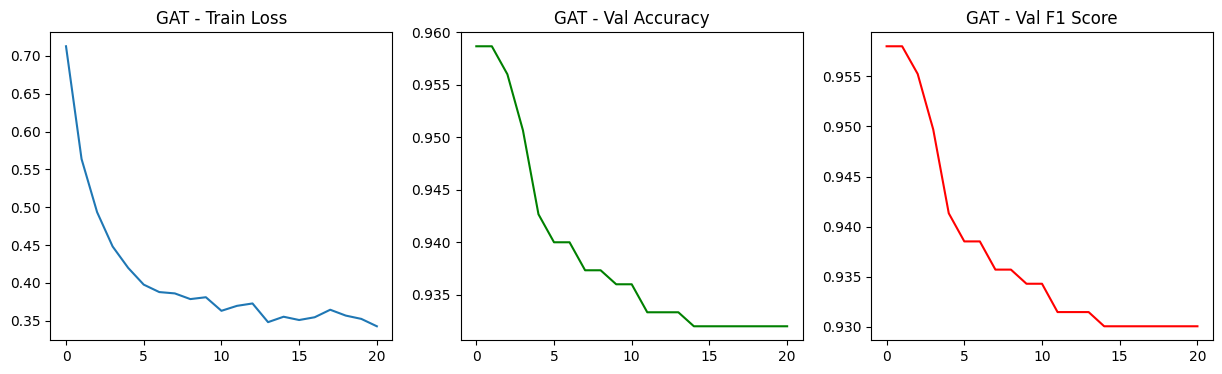

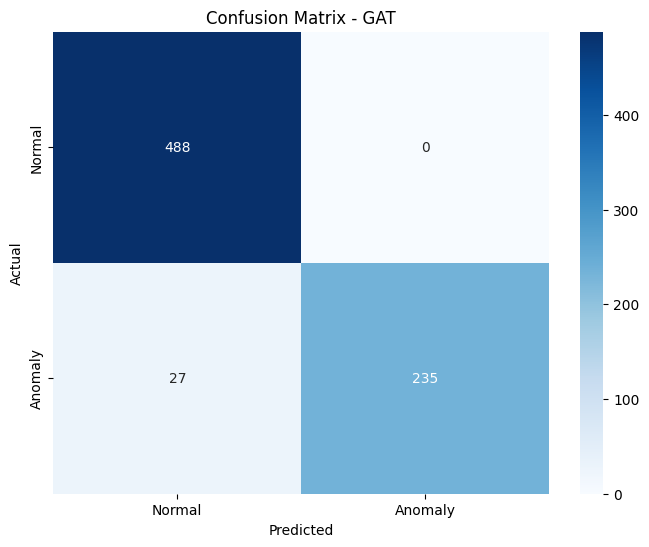

Test Accuracy: 0.9640

Classification Report:
              precision    recall  f1-score   support

      Normal     0.9476    1.0000    0.9731       488
     Anomaly     1.0000    0.8969    0.9457       262

    accuracy                         0.9640       750
   macro avg     0.9738    0.9485    0.9594       750
weighted avg     0.9659    0.9640    0.9635       750


 GAT Model Results: {'accuracy': 0.964}


In [4]:
print("Graph Attention Network (GAT)")

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support, f1_score
from sklearn.model_selection import train_test_split

# Graph building function
def build_graph_for_training(df, num_flows=5000, num_hosts=200, anomaly_ratio=0.3):
    print(f" Building graph with {num_flows} flows...")
    
    df_sample = df.head(num_flows).copy()
    
    # Fix labels
    if 'Label' in df_sample.columns:
        df_sample['Label'] = pd.to_numeric(df_sample['Label'], errors='coerce').fillna(0).astype(int)
    else:
        df_sample['Label'] = 0
    
    # Balance dataset
    current_anomalies = (df_sample['Label'] == 1).sum()
    target_anomalies = int(num_flows * anomaly_ratio)
    add_anomalies = target_anomalies - current_anomalies
    
    if add_anomalies > 0:
        normal_indices = df_sample[df_sample['Label'] == 0].index.tolist()
        anomaly_indices = np.random.choice(normal_indices, add_anomalies, replace=False)
        
        for idx in anomaly_indices:
            attack_type = np.random.choice(['port_scan', 'ddos', 'data_exfiltration', 'brute_force', 'botnet'])
            if attack_type == 'port_scan':
                df_sample.loc[idx, 'Destination Port'] = np.random.randint(1000, 65535)
                df_sample.loc[idx, 'Flow Duration'] = np.random.randint(1, 1000)
                df_sample.loc[idx, 'Total Fwd Packets'] = np.random.randint(50, 200)
            elif attack_type == 'ddos':
                df_sample.loc[idx, 'Flow Duration'] = np.random.randint(1, 100)
                df_sample.loc[idx, 'Total Fwd Packets'] = np.random.randint(100, 1000)
                df_sample.loc[idx, 'Total Length of Fwd Packets'] = np.random.randint(5000, 50000)
            elif attack_type == 'data_exfiltration':
                df_sample.loc[idx, 'Total Length of Fwd Packets'] = np.random.randint(10000, 100000)
                df_sample.loc[idx, 'Total Backward Packets'] = np.random.randint(1, 10)
            elif attack_type == 'brute_force':
                df_sample.loc[idx, 'Destination Port'] = np.random.choice([22, 23, 3389, 5900])
                df_sample.loc[idx, 'Flow Duration'] = np.random.randint(100, 1000)
                df_sample.loc[idx, 'Total Fwd Packets'] = np.random.randint(20, 100)
            elif attack_type == 'botnet':
                df_sample.loc[idx, 'Flow Duration'] = np.random.randint(5000, 30000)
                df_sample.loc[idx, 'Total Fwd Packets'] = np.random.randint(10, 50)
            df_sample.loc[idx, 'Label'] = 1
    
    print(f" Label distribution: {df_sample['Label'].value_counts().to_dict()}")
    
    # Select features
    numeric_cols = [c for c in df_sample.columns if c != 'Label' and pd.api.types.is_numeric_dtype(df_sample[c])]
    feature_cols = numeric_cols[:15]
    for col in feature_cols:
        df_sample[col] = pd.to_numeric(df_sample[col], errors='coerce').fillna(0)
    
    # Flow features
    x_flow = torch.tensor(df_sample[feature_cols].values, dtype=torch.float)
    
    # Graph edges
    edge_index = []
    for i in range(len(df_sample)):
        host1 = num_flows + (i % num_hosts)
        host2 = num_flows + ((i + 1) % num_hosts)
        host3 = num_flows + ((i + 5) % num_hosts)
        edge_index.extend([[i, host1], [i, host2], [i, host3]])
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    
    # Host features
    x_host = torch.zeros((num_hosts, x_flow.shape[1]))
    host_counts = torch.zeros(num_hosts)
    for i in range(len(df_sample)):
        host1_idx = i % num_hosts
        host2_idx = (i + 1) % num_hosts
        host3_idx = (i + 5) % num_hosts
        x_host[host1_idx] += x_flow[i]
        x_host[host2_idx] += x_flow[i]
        x_host[host3_idx] += x_flow[i]
        host_counts[host1_idx] += 1
        host_counts[host2_idx] += 1
        host_counts[host3_idx] += 1
    for i in range(num_hosts):
        if host_counts[i] > 0:
            x_host[i] = x_host[i] / host_counts[i]
    
    # Combine features
    x = torch.cat([x_flow, x_host], dim=0)
    
    # Labels
    y_flow = torch.tensor(df_sample['Label'].values, dtype=torch.long)
    y_host = torch.full((num_hosts,), -1, dtype=torch.long)
    y = torch.cat([y_flow, y_host], dim=0)
    
    data = Data(x=x, edge_index=edge_index, y=y)
    data.num_flows = len(df_sample)
    data.num_hosts = num_hosts
    
    # Train/val/test splits
    flow_indices = np.arange(data.num_flows)
    flow_labels = y_flow.numpy()
    train_idx, temp_idx = train_test_split(flow_indices, test_size=0.3, stratify=flow_labels, random_state=42)
    val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, stratify=flow_labels[temp_idx], random_state=42)
    
    train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    train_mask[train_idx] = True
    val_mask[val_idx] = True
    test_mask[test_idx] = True
    
    data.train_mask = train_mask
    data.val_mask = val_mask
    data.test_mask = test_mask
    
    print(f" Graph built: {data.num_nodes} nodes, {data.num_edges} edges")
    print(f" Train: {train_mask.sum().item()}, Val: {val_mask.sum().item()}, Test: {test_mask.sum().item()}")
    
    return data

# Robust GAT Model
class RobustGAT(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=2, heads=4, dropout=0.3):
        super(RobustGAT, self).__init__()
        self.dropout = dropout
        self.gat1 = GATConv(input_dim, hidden_dim, heads=heads, dropout=dropout)
        self.bn1 = nn.BatchNorm1d(hidden_dim * heads)
        self.gat2 = GATConv(hidden_dim * heads, hidden_dim, heads=heads, dropout=dropout)
        self.bn2 = nn.BatchNorm1d(hidden_dim * heads)
        self.gat3 = GATConv(hidden_dim * heads, hidden_dim // 2, heads=2, dropout=dropout)
        self.bn3 = nn.BatchNorm1d((hidden_dim // 2) * 2)
        self.output = nn.Linear((hidden_dim // 2) * 2, output_dim)
        self.dropout_layer = nn.Dropout(dropout)
        
    def forward(self, x, edge_index):
        x = F.elu(self.bn1(self.gat1(x, edge_index)))
        x = self.dropout_layer(x)
        x = F.elu(self.bn2(self.gat2(x, edge_index)))
        x = self.dropout_layer(x)
        x = F.elu(self.bn3(self.gat3(x, edge_index)))
        x = self.dropout_layer(x)
        x = self.output(x)
        return F.log_softmax(x, dim=1)

# Training function
def train_gnn_model(model, data, model_name='GAT', epochs=100, lr=0.001, weight_decay=1e-4):
    flow_mask = data.y != -1
    labels = data.y[flow_mask]
    class_counts = torch.bincount(labels)
    class_weights = 1.0 / class_counts.float()
    class_weights = class_weights / class_weights.sum()
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=10, factor=0.5)
    criterion = nn.NLLLoss(weight=class_weights)
    
    train_losses, val_accuracies, val_f1_scores = [], [], []
    best_val_f1, patience, patience_counter = 0, 20, 0
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_out = model(data.x, data.edge_index)
            val_pred = val_out[data.val_mask].argmax(dim=1)
            val_true = data.y[data.val_mask]
            val_acc = (val_pred == val_true).float().mean().item()
            _, _, f1, _ = precision_recall_fscore_support(val_true.cpu(), val_pred.cpu(), average='weighted')
        
        scheduler.step(f1)
        train_losses.append(loss.item())
        val_accuracies.append(val_acc)
        val_f1_scores.append(f1)
        
        # Early stopping
        if f1 > best_val_f1:
            best_val_f1 = f1
            patience_counter = 0
            torch.save(model.state_dict(), f'best_{model_name.lower()}.pth')
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f" Early stopping at epoch {epoch}")
            break
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch} | Loss: {loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {f1:.4f}")
    
    # Load best model
    model.load_state_dict(torch.load(f'best_{model_name.lower()}.pth'))
    return model, train_losses, val_accuracies, val_f1_scores

# Evaluation function
def evaluate_gnn_model(model, data, model_name='GAT'):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        test_pred = out[data.test_mask].argmax(dim=1)
        test_true = data.y[data.test_mask]
        test_accuracy = accuracy_score(test_true.cpu(), test_pred.cpu())
        
        # Confusion matrix
        cm = confusion_matrix(test_true.cpu(), test_pred.cpu())
        plt.figure(figsize=(8,6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Normal','Anomaly'], yticklabels=['Normal','Anomaly'])
        plt.title(f'Confusion Matrix - {model_name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
        
        print(f"Test Accuracy: {test_accuracy:.4f}")
        print("\nClassification Report:")
        print(classification_report(test_true.cpu(), test_pred.cpu(), target_names=['Normal','Anomaly'], digits=4))
        
        return {'accuracy': test_accuracy}


# Plot training history
def plot_training_history(train_losses, val_accuracies, val_f1_scores, model_name='GAT'):
    plt.figure(figsize=(15,4))
    plt.subplot(1,3,1)
    plt.plot(train_losses, label='Train Loss')
    plt.title(f'{model_name} - Train Loss')
    plt.subplot(1,3,2)
    plt.plot(val_accuracies, label='Val Acc', color='green')
    plt.title(f'{model_name} - Val Accuracy')
    plt.subplot(1,3,3)
    plt.plot(val_f1_scores, label='Val F1', color='red')
    plt.title(f'{model_name} - Val F1 Score')
    plt.show()

# Main execution
def run_gat_model():
    print("="*80)
    print(" GAT MODEL FOR INTRUSION DETECTION")
    print("="*80)
    
    # Load dataset
    df_cleaned = pd.read_csv("/kaggle/working/itu_ml5g_cleaned2.csv", low_memory=False)
    data = build_graph_for_training(df_cleaned, num_flows=5000, num_hosts=200, anomaly_ratio=0.35)
    
    input_dim = data.x.shape[1]
    model = RobustGAT(input_dim=input_dim, hidden_dim=64, output_dim=2)
    
    # Train
    trained_model, train_losses, val_accuracies, val_f1_scores = train_gnn_model(
        model, data, model_name='GAT', epochs=100, lr=0.001
    )
    
    # Plot training history
    plot_training_history(train_losses, val_accuracies, val_f1_scores, model_name='GAT')
    
    # Evaluate
    results = evaluate_gnn_model(trained_model, data, model_name='GAT')
    print(f"\n GAT Model Results: {results}")
    
    return trained_model, data, results

# Run the model
if __name__ == "__main__":
    trained_model, graph_data, results = run_gat_model()
